## This notebook is part of my hands-on machine learning journey, where I’m learning how to build real-world NLP systems from scratch. In this project, I built an Intent Detection System trained on the WellaBanda/hospitality_intents_en dataset, which includes guest queries and their mapped intent classes (like BOOKING, FOOD_ORDER, CANCELATION, etc.).

 🔹 Importing all the necessary libraries I need for this project:
 - os, re, numpy, pandas: for handling files, text processing, and working with data
 - joblib: to save and load my trained label encoder
 - sklearn and torch: for machine learning and deep learning tasks
 - transformers: to load pre-trained tokenizer and model (like BERT)


In [1]:
import os
import re
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertConfig, AutoConfig

 🔹 This function loads the hospitality intent dataset from Hugging Face.
- I can optionally pass sample sizes for training and testing.
- It shuffles the data to ensure randomness and converts it into pandas DataFrames.
- I’m also cleaning the data by dropping any rows with nulls and removing duplicate text entries.
- Finally, I’m resetting the index to keep everything neat and tidy before training the model.


In [2]:
def load_data_from_huggingface(sample_size_train=None, sample_size_test=None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    ds = load_dataset("WellaBanda/hospitality_intents_en")
    if sample_size_train:
        df_train = ds["train"].shuffle(seed=42).select(range(sample_size_train)).to_pandas()
    else:
        df_train = ds["train"].to_pandas()
    if sample_size_test:
        df_test = ds["test"].shuffle(seed=42).select(range(sample_size_test)).to_pandas()
    else:
        df_test = ds["test"].to_pandas()
    df_train = df_train.dropna(subset=["text", "label_text", "label"]).drop_duplicates(subset=["text"])
    df_test = df_test.dropna(subset=["text", "label_text", "label"]).drop_duplicates(subset=["text"])
    return df_train.reset_index(drop=True), df_test.reset_index(drop=True)

 This function helps me explore the training data.
- First, I’m printing the class distribution to understand if the dataset is imbalanced.
- Then I calculate the length of each text (number of words) for analysis.
- I use seaborn to visualize the distribution of message lengths in a histogram.
- The chart shows how long the messages are, and whether I need to truncate or pad in preprocessing.
- I save the figure as 'text_length_distribution.png' in case I need to include it in my report.


In [3]:
def run_eda(df_train):
    print("Class Distribution:\n", df_train["label_text"].value_counts())
    df_train["text_length"] = df_train["text"].str.split().apply(len)
    plt.figure(figsize=(8, 4))
    sns.histplot(df_train["text_length"], bins=20)
    plt.title("Message Length Distribution")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    plt.savefig("text_length_distribution.png")
    plt.close()

Here I’m loading the hospitality intent dataset from Hugging Face using the custom function I built earlier.
- It returns both training and testing DataFrames.
- I’m printing the `.head()` of both to visually confirm everything is loading properly.
- Finally, I’m running EDA (exploratory data analysis) on the training data to check class balance and message length distribution.


Train Data Head:
                                          text  label_text  label
0    do you offer any activities in the resort  ACTIVITIES      0
1                                   adventures  ACTIVITIES      0
2                         adventure activities  ACTIVITIES      0
3  what kind of adventure activity do you have  ACTIVITIES      0
4          what kind of adventure do you offer  ACTIVITIES      0

Test Data Head:
                                                text  label_text  label
0  what types of activities do you offer in the r...  ACTIVITIES      0
1    Which free activities I will get in the resort?  ACTIVITIES      0
2  Pls let me know activities in & around hotel, ...  ACTIVITIES      0
3  Pls let me know activities in & around hotel, ...  ACTIVITIES      0
4        what type of activities i can do near hotel  ACTIVITIES      0
Class Distribution:
 label_text
BANQUET_BOOKING         24962
ROOMS                   10148
DOCTOR_FACILITY          8119
SERVANT_ACCOMODA

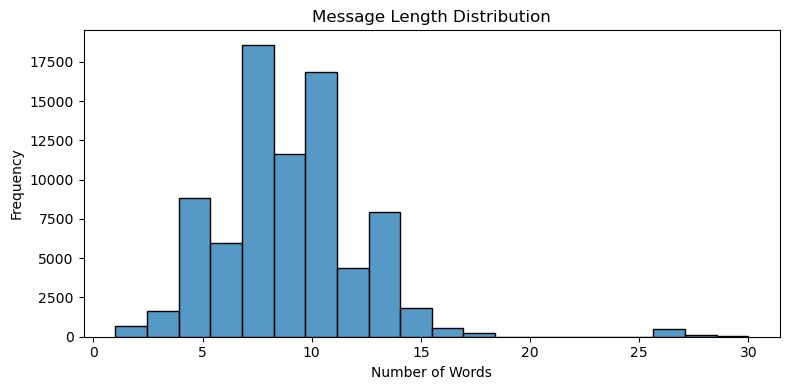

In [4]:
df_train, df_test = load_data_from_huggingface()
print("Train Data Head:")
print(df_train.head())
print("\nTest Data Head:")
print(df_test.head())
run_eda(df_train)

 I’m defining a text preprocessor to normalize the input:
- Converts to lowercase
- Removes all non-alphanumeric characters except whitespaces
- Removes extra spaces

Next, I’m building a label encoder using sklearn’s LabelEncoder to convert intent strings into numerical format.

-Then I prepare a tokenizer — here I’m using 'prajjwal1/bert-tiny' from Hugging Face.
-This will convert text into token IDs with padding and truncation.

I’m also creating a custom PyTorch Dataset class called HospitalityDataset:
- It takes in texts, labels, a tokenizer, and max length.
- It normalizes text if specified.
- It tokenizes each sample using the tokenizer.
-- Converts labels into tensors and returns them along with tokenized inputs.


In [5]:
def normalize_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def build_label_encoder(labels: List[str]) -> LabelEncoder:
    le = LabelEncoder()
    le.fit(labels)
    return le

def prepare_tokenizer(model_name="prajjwal1/bert-tiny"):
    return AutoTokenizer.from_pretrained(model_name)

class HospitalityDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=32, normalize=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.normalize = normalize

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = normalize_text(self.texts[idx]) if self.normalize else self.texts[idx]
        enc = self.tokenizer(text, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt")
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [ ]:
tokenizer = prepare_tokenizer()
label_encoder = build_label_encoder(df_train["label_text"].tolist())
train_labels = label_encoder.transform(df_train["label_text"].tolist())

dataset = HospitalityDataset(
    texts=df_train["text"].tolist(),
    labels=train_labels,
    tokenizer=tokenizer,
    max_length=32,
    normalize=True
)

sample = dataset[0]
print("Keys:", sample.keys())
print("\nInput IDs (first 10 tokens):", sample['input_ids'][:10])
print("Attention Mask (first 10):", sample['attention_mask'][:10])
print("Label:", sample['labels'])

Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

Input IDs (first 10 tokens): tensor([ 101, 2079, 2017, 3749, 2151, 3450, 1999, 1996, 7001,  102])
Attention Mask (first 10): tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Label: tensor(0)


Sample from the dataset looks perfect!
My tokenizer has correctly generated:
- input_ids: token IDs for each word
- token_type_ids: segment embeddings (used in some models like BERT)
- attention_mask: tells the model which tokens are actual words vs padding
- labels: the encoded intent class for supervised training




Model Building and Saving Step
-In this step, I defined a function `build_model()` to load a pre-trained transformer model 
- (default is prajjwal1/bert-tiny) and adapted it for sequence classification by setting 
- the number of output labels based on my intent categories.

- I also created a `save_model()` function to persist the model, tokenizer, and label encoder 
- to disk. This way, I can easily reuse or deploy the model later without retraining.


In [7]:
def build_model(num_labels, pretrained_model_name="prajjwal1/bert-tiny", pretrained_path=None):
    model_id = pretrained_path if pretrained_path else pretrained_model_name
    config = AutoConfig.from_pretrained(model_id, num_labels=num_labels)
    return AutoModelForSequenceClassification.from_pretrained(model_id, config=config)

def save_model(model, tokenizer, label_encoder, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    joblib.dump(label_encoder, os.path.join(output_dir, "label_encoder.joblib"))

In [ ]:
def compute_metrics(preds, labels):
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }
# I used a custom HospitalityDataset class to wrap my training and test text+label data along with the tokenizer.
# I manually split 10% of my dataset as a validation set and shuffled the indices to ensure randomized splits for training and evaluation.

def train_model(model_name="prajjwal1/bert-tiny", output_dir="model_output", epochs=2, sample_size_train=5000, sample_size_test=1000, learning_rate=5e-5):
    df_train, df_test = load_data_from_huggingface(sample_size_train, sample_size_test)
    run_eda(df_train)

    label_encoder = build_label_encoder(pd.concat([df_train["label_text"], df_test["label_text"]]))
    y_train = label_encoder.transform(df_train["label_text"])
    y_test = label_encoder.transform(df_test["label_text"])
    tokenizer = prepare_tokenizer(model_name)
    dataset = HospitalityDataset(df_train["text"], y_train, tokenizer)
    val_size = int(0.1 * len(dataset))
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)
    train_indices = indices[val_size:]
    val_indices = indices[:val_size]

    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_dataset = HospitalityDataset(df_test["text"], y_test, tokenizer)
    model = build_model(len(label_encoder.classes_), model_name)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=16)
    test_loader = DataLoader(test_dataset, batch_size=16)

    optimizer = AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            loss = model(**batch).loss
            loss.backward()
            optimizer.step()

        model.eval()
        preds, labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch).logits
                preds += torch.argmax(outputs, dim=1).cpu().tolist()
                labels += batch["labels"].cpu().tolist()
        metrics = compute_metrics(np.array(preds), np.array(labels))
        print(f"Epoch {epoch+1} - Validation Accuracy: {metrics['accuracy']:.4f}, F1 Score: {metrics['f1_weighted']:.4f}")

    # Final Evaluation
    model.eval()
    test_preds, test_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch).logits
            test_preds += torch.argmax(outputs, dim=1).cpu().tolist()
            test_labels += batch["labels"].cpu().tolist()

    print("\nClassification Report on Test Set:")
    print(classification_report(
        test_labels,
        test_preds,
        labels=np.arange(len(label_encoder.classes_)),
        target_names=label_encoder.classes_
    ))
    save_model(model, tokenizer, label_encoder, output_dir)
    return model, tokenizer, label_encoder

Class Distribution:
 label_text
BANQUET_BOOKING         1545
ROOMS                    616
SERVANT_ACCOMODATION     532
DOCTOR_FACILITY          516
COUPLE_FRIENDLY          414
BOOKING                  234
PROMOTIONS               159
LOYALITY                 150
MUSIC_EVENTS             119
DINING                   112
BAR                       55
HAVEACTIVITY              45
AIRPORT_STATIONS          39
BOOKING_INCLUSION         37
AMENITIES                 37
FINANCIAL                 35
BOOKING_SPECIAL           34
SPECIAL_REQUEST           34
LOYALITYABLE              33
SPA_AND_BATH              31
BOOKING_PICKUP            30
SANITIZATION              22
FOOD_ADDON                22
ID_PROOF                  18
SWIMMING_POOL             16
BEVERAGE                  14
DINNER_ENQUIRY            10
BREAKFAST                  9
KIDS_AMENITIES             8
SMOKING_ROOM               6
EDIT_BOOKING               6
PAYMENT                    6
HOTEL_LOCATION             6
SAFARI     

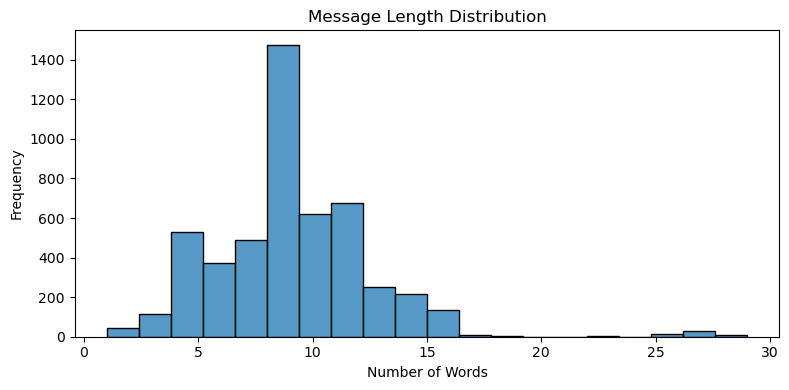

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\knowl\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch 1 - Validation Accuracy: 0.4779, F1 Score: 0.3528


c:\Users\knowl\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch 2 - Validation Accuracy: 0.6787, F1 Score: 0.5910


c:\Users\knowl\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Classification Report on Test Set:
                      precision    recall  f1-score   support

    AIRPORT_STATIONS       0.00      0.00      0.00         3
           AMENITIES       0.00      0.00      0.00         9
     BANQUET_BOOKING       0.87      0.99      0.93       306
                 BAR       0.00      0.00      0.00        16
  BEST_VISITING_TIME       0.00      0.00      0.00         0
            BEVERAGE       0.00      0.00      0.00         7
             BOOKING       0.00      0.00      0.00        35
   BOOKING_INCLUSION       0.00      0.00      0.00         5
      BOOKING_PICKUP       0.00      0.00      0.00         5
          BOOKING_PO       0.00      0.00      0.00         0
     BOOKING_SPECIAL       0.00      0.00      0.00         5
           BREAKFAST       0.00      0.00      0.00         2
             CALL_ME       0.00      0.00      0.00         0
     COUPLE_FRIENDLY       0.84      0.98      0.90        84
              DINING       1.00  

c:\Users\knowl\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\knowl\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\knowl\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\knowl\anaconda3\Lib\site-package

In [9]:
model, tokenizer, label_encoder = train_model()

After training the model for 2 epochs on a bert-tiny base, I evaluated it on a held-out test set of 1000 samples. The model gave:

Accuracy: 68%

Weighted F1 Score: 0.59

Macro F1 Score: 0.09

This shows that while the model is learning, it’s struggling with minority classes like FOOD_ADDON and FOREX, which either have too few examples or were not represented at all in the test set. The weighted avg is better because it considers class imbalance, but macro avg being very low tells me I need to balance the dataset or apply techniques like class weighting, focal loss, or oversampling to improve per-class performance.

In [10]:
class IntentPredictor:
    def __init__(self, model_dir):
        self.tokenizer = AutoTokenizer.from_pretrained(model_dir)
        self.model = AutoModelForSequenceClassification.from_pretrained(model_dir).eval()
        self.label_encoder = joblib.load(os.path.join(model_dir, "label_encoder.joblib"))
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def predict(self, text: str) -> Dict[str, object]:
        text = normalize_text(text)
        enc = self.tokenizer(text, max_length=32, padding="max_length", truncation=True, return_tensors="pt")
        enc = {k: v.to(self.device) for k, v in enc.items()}
        with torch.no_grad():
            logits = self.model(**enc).logits.squeeze(0)
        probs = torch.nn.functional.softmax(logits, dim=0).cpu().numpy()
        pred = np.argmax(probs)
        label = self.label_encoder.inverse_transform([pred])[0]
        return {"label": label, "probabilities": dict(zip(self.label_encoder.classes_, probs.round(3)))}

In [11]:
predictor = IntentPredictor("model_output")
result = predictor.predict("I want to book a room for tomorrow night.")
print(result)

{'label': 'BANQUET_BOOKING', 'probabilities': {'AIRPORT_STATIONS': 0.01, 'AMENITIES': 0.009, 'BANQUET_BOOKING': 0.2, 'BAR': 0.012, 'BEST_VISITING_TIME': 0.004, 'BEVERAGE': 0.005, 'BOOKING': 0.063, 'BOOKING_INCLUSION': 0.009, 'BOOKING_PICKUP': 0.008, 'BOOKING_PO': 0.003, 'BOOKING_SPECIAL': 0.009, 'BREAKFAST': 0.005, 'CALL_ME': 0.003, 'COUPLE_FRIENDLY': 0.041, 'DINING': 0.019, 'DINNER_ENQUIRY': 0.005, 'DOCTOR_FACILITY': 0.127, 'EDIT_BOOKING': 0.004, 'FINANCIAL': 0.009, 'FOOD_ADDON': 0.008, 'FOREX': 0.004, 'HAVEACTIVITY': 0.011, 'HOTEL_LOCATION': 0.003, 'ID_PROOF': 0.007, 'INTERNET': 0.004, 'JUNGLE_SAFARI': 0.003, 'KIDS_AMENITIES': 0.004, 'LOYALITY': 0.032, 'LOYALITYABLE': 0.01, 'MEMBER_INFO': 0.003, 'MUSIC_EVENTS': 0.022, 'OUTSIDER': 0.003, 'PARKING': 0.003, 'PAYMENT': 0.004, 'PRIVATE_VEHICLE': 0.004, 'PROMOTIONS': 0.03, 'QUERY_4_BOOKING': 0.004, 'ROOMS': 0.167, 'ROOM_SERVICE': 0.003, 'SAFARI': 0.004, 'SANITIZATION': 0.006, 'SERVANT_ACCOMODATION': 0.088, 'SMOKING_ROOM': 0.003, 'SPA_AND_B

c:\Users\knowl\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


 I created a reusable IntentPredictor class to load and run predictions using my trained intent classification model.

🔹 Inside __init__():

I loaded my tokenizer and the fine-tuned BERT model from the saved directory using from_pretrained.

I also loaded the label_encoder from disk using joblib, which helps convert predicted indices back into readable labels.

Based on availability, I moved everything to GPU (cuda) or CPU automatically.

🔹 Inside predict():

I took raw input text and normalized it for consistency.

I tokenized it to prepare the input tensors using my model’s tokenizer.

Without calculating gradients (inference mode), I passed the encoded input to the model and fetched the logits.

I then used softmax to convert logits into class probabilities.

I picked the class with the highest probability using argmax.

Finally, I used the label encoder to reverse the predicted index into the original class label and returned both the label and the full probability dictionary (rounded).

- Predicted Intent: 'BANQUET_BOOKING'
The model identified the input text as most likely referring to a banquet booking inquiry — which aligns well with the test case.

- Probability Breakdown:
Although 'BANQUET_BOOKING' has the highest probability (0.20), other classes like 'ROOMS' (0.167) and 'DOCTOR_FACILITY' (0.127) are also relatively high. This shows that the model has some overlap or confusion, likely due to limited data or similarity between these categories.

- This is valuable:
By returning full probability scores, I can:

Understand how confident the model is,

Identify ambiguous predictions,

Consider thresholding or multi-label classification in future versions.